# Wasserstein GAN

The Wasserstein GAN [(paper here)](https://arxiv.org/abs/1701.07875) is a improve GAN model that improves learning 
stability and helps get rid of problems like mode collapse, which we experienced with our first GAN model.

In [1]:
import random

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.autograd as autograd
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline

manualSeed = random.randint(1, 10000)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

print("Seed:", manualSeed)

Seed: 4304


In [2]:
batch_size = 64
img_shape = (3, 64, 64)

# Create the Datasets

transform = transforms.Compose(
    [
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

dataset_mountains = dset.ImageFolder(root="../data/mountains", transform=transform)
dataset_two = dset.ImageFolder(root="../data/mountains", transform=transform)
dataset_three = dset.ImageFolder(root="../data/mountains", transform=transform)

dataloader_mountains = torch.utils.data.DataLoader(dataset_mountains, batch_size=batch_size, shuffle=True, num_workers=2)
dataloader_two = torch.utils.data.DataLoader(dataset_two, batch_size=batch_size, shuffle=True, num_workers=2)
dataloader_three = torch.utils.data.DataLoader(dataset_three, batch_size=batch_size, shuffle=True, num_workers=2)

# Set To Zero For CPU Mode

ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu == 1) else "cpu")

print("Running On Device:", device)

Running On Device: cuda:0


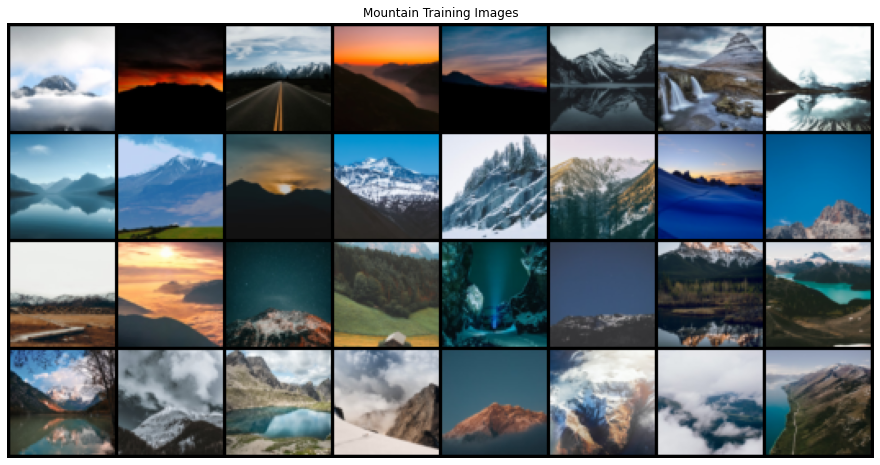

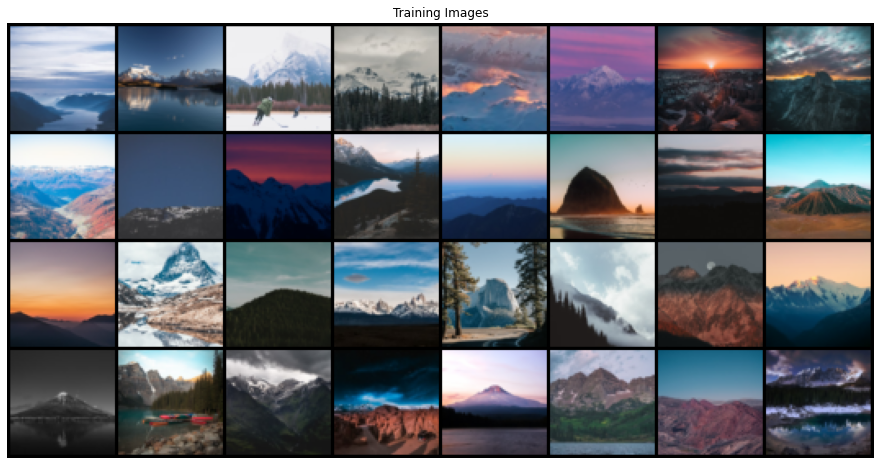

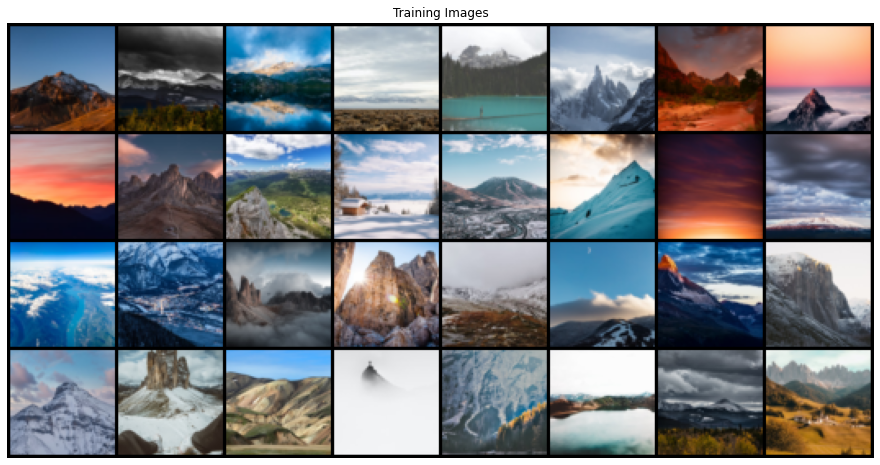

In [3]:
# Show Some Training Images

real_batch = next(iter(dataloader_mountains))
plt.figure(figsize=(16,8))
plt.axis("off")
plt.title("Mountain Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:32], padding=2, normalize=True).cpu(),(1,2,0)))

real_batch = next(iter(dataloader_two))
plt.figure(figsize=(16,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:32], padding=2, normalize=True).cpu(),(1,2,0)))

real_batch = next(iter(dataloader_three))
plt.figure(figsize=(16,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:32], padding=2, normalize=True).cpu(),(1,2,0)))

In [4]:
class Generator(nn.Module):
    
    def __init__(self, ngpu):
        
        super(Generator, self).__init__()

        self.ngpu = ngpu
        
        def block(in_feat, out_feat, normalize=True):
            
            layers = [nn.Linear(in_feat, out_feat)]
            
            if normalize:
                
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(100, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        return img

In [5]:
class Discriminator(nn.Module):
    
    def __init__(self, ngpu):
        
        super(Discriminator, self).__init__()
        
        self.ngpu = ngpu
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity

In [6]:
def compute_gradient_penalty(D, real_samples, fake_samples):

    alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    
    return gradient_penalty

In [15]:
def main_loop(dataloader, netD, netG, epochs):

    Tensor = torch.cuda.FloatTensor if device.type == 'cuda' else torch.FloatTensor

    img_list = []
    batches_done = 0
    fixed_noise = Variable(Tensor(np.random.normal(0, 1, (img_shape[0], 100))))
    iters = 0

    optimizer_G = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))

    for epoch in range(epochs):
    
        for i, (imgs, _) in enumerate(dataloader):

            # Configure input
            real_imgs = Variable(imgs.type(Tensor))

            # ---------------------
            #  Train Discriminator
            # ---------------------

            optimizer_D.zero_grad()

            # Sample noise as generator input
            z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], 100))))

            # Generate a batch of images
            fake_imgs = netG(z)

            # Real images
            real_validity = netD(real_imgs)
            # Fake images
            fake_validity = netD(fake_imgs)
            # Gradient penalty
            gradient_penalty = compute_gradient_penalty(netD, real_imgs.data, fake_imgs.data)
            # Adversarial loss
            d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + 10 * gradient_penalty

            d_loss.backward()
            optimizer_D.step()

            optimizer_G.zero_grad()

            # Train the generator every n_critic steps
            if i % 5 == 0:

                # -----------------
                #  Train Generator
                # -----------------

                # Generate a batch of images
                fake_imgs = netG(z)
                # Loss measures generator's ability to fool the discriminator
                # Train on fake images
                fake_validity = netD(fake_imgs)
                g_loss = -torch.mean(fake_validity)

                g_loss.backward()
                optimizer_G.step()

                print("[Epoch %d/%d] [Loss_D: %.4f] [Loss_G: %.4f]" % (epoch, epochs, d_loss.item(), g_loss.item()))

                batches_done += 5
            
                # Check how the generator is doing by saving G's output on fixed_noise
                if (iters % 500 == 0) or ((epoch == epochs - 1) and (i == len(dataloader) - 1)):
                    
                    with torch.no_grad():

                        fake = netG(fixed_noise).detach().cpu()
                
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
                
                iters += 1

In [16]:
def show_results(dataloader, img_list):
    
    # Grab a batch of real images from the dataloader
    real_batch = next(iter(dataloader))

    # Plot the real images
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

    # Plot the fake images from the last epoch
    plt.subplot(1,2,2)
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(img_list[-1],(1,2,0)))
    plt.show()
    

In [17]:
def do_run(dataloader, epochs):

    netG = Generator(ngpu).to(device)
    netD = Discriminator(ngpu).to(device)

    img_list = main_loop(dataloader, netG, netD, epochs)
    
    fig = plt.figure(figsize=(8,8))
    plt.axis("off")
    ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
    ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

    HTML(ani.to_jshtml())
    
    show_results(dataloader, img_list)

In [18]:
do_run(dataloader_mountains, 50)


RuntimeError: size mismatch, m1: [64 x 100], m2: [12288 x 512] at C:/w/b/windows/pytorch/aten/src\THC/generic/THCTensorMathBlas.cu:283